In [1]:
import uproot
import numpy as np
import sys
import os
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import itertools
import awkward as ak
from scipy.optimize import curve_fit
%matplotlib inline

In [2]:
file = uproot.open("tracking_losses_ntuple_Dst0ToD0EE.root:PrDebugTrackingLosses.PrDebugTrackingTool/Tuple;1")


#selektiere nur elektronen von D*0->D0ee und nur solche mit einem momentum von unter 5 GeV 
allcolumns = file.arrays()
found = allcolumns[(allcolumns.isElectron) & (~allcolumns.lost) & (allcolumns.fromSignal) & (allcolumns.p < 5e3)] #D: 2591
lost = allcolumns[(allcolumns.isElectron) & (allcolumns.lost) & (allcolumns.fromSignal) & (allcolumns.p < 5e3)] #D: 1908

#ak.num(lost, axis=0)
ak.num(allcolumns[(allcolumns.fromPairProd) & (allcolumns.isElectron) & (~allcolumns.lost) & (allcolumns.fromSignal)],axis=0)
#found[0]

51

In [3]:
def t_eff(found, lost, axis = 0):
    sel = ak.num(found, axis=axis)
    des = ak.num(lost, axis=axis)
    return sel/(sel + des)

def eff_err(found, lost):
    n_f = ak.num(found, axis=0)
    n_all = ak.num(found, axis=0) + ak.num(lost,axis=0)
    return 1/n_all * np.sqrt(np.abs(n_f*(1-n_f/n_all)))


print("eff all = ", t_eff(found, lost), "+/-", eff_err(found, lost))

eff all =  0.5759057568348522 +/- 0.007367987865301135


In [4]:

#statistics

nobrem_found = found[found["brem_photons_pe_length"]==0]
nobrem_lost = lost[lost["brem_photons_pe_length"]==0]

"""
die effizienz mit der wir elektronen finden, die keine bremsstrahlung gemacht haben, ist nicht besonders gut, aber trotzdem besser als
für alle elektronen.
Auch hier handelt es sich um eine recht geringe sample size (~350)
"""

t_eff(nobrem_found, nobrem_lost)
#ak.num(nobrem_lost, axis=0)

0.7960893854748603

In [5]:
#try excluding all photons that originate from a vtx @ z>9500mm
#ignore all brem vertices @ z>9500mm 

#found

brem_e_f = found["brem_photons_pe"]
brem_z_f = found["brem_vtx_z"]
e_f = found["energy"]
length_f = found["brem_vtx_z_length"]

brem_f = ak.ArrayBuilder()

for itr in range(ak.num(found,axis=0)):
    brem_f.begin_record()
    #[:,"energy"] energy
    brem_f.field("energy").append(e_f[itr])
    #[:,"photon_length"] number of vertices
    brem_f.field("photon_length").integer(length_f[itr])
    #[:,"brem_photons_pe",:] photon energy 
    brem_f.field("brem_photons_pe").append(brem_e_f[itr])
    #[:,"brem_vtx_z",:] brem vtx z
    brem_f.field("brem_vtx_z").append(brem_z_f[itr])
    brem_f.end_record()

brem_f = ak.Array(brem_f)

#lost

brem_e_l = lost["brem_photons_pe"]
brem_z_l = lost["brem_vtx_z"]
e_l = lost["energy"]
length_l = lost["brem_vtx_z_length"]

brem_l = ak.ArrayBuilder()

for itr in range(ak.num(lost,axis=0)):
    brem_l.begin_record()
    #[:,"energy"] energy
    brem_l.field("energy").append(e_l[itr])
    #[:,"photon_length"] number of vertices
    brem_l.field("photon_length").integer(length_l[itr])
    #[:,"brem_photons_pe",:] photon energy 
    brem_l.field("brem_photons_pe").append(brem_e_l[itr])
    #[:,"brem_vtx_z",:] brem vtx z
    brem_l.field("brem_vtx_z").append(brem_z_l[itr])
    brem_l.end_record()

brem_l = ak.Array(brem_l)




brem_f[0]

<Record {energy: 2.04e+03, ...} type='{energy: float64, photon_length: int6...'>

In [6]:
acc_brem_found = ak.ArrayBuilder()

for itr in range(ak.num(brem_f, axis=0)):
    acc_brem_found.begin_record()
    acc_brem_found.field("energy").real(brem_f[itr,"energy"])
    
    acc_brem_found.field("brem_photons_pe")
    acc_brem_found.begin_list()
    for jentry in range(brem_f[itr, "photon_length"]):
        if brem_f[itr, "brem_vtx_z", jentry]>9500:
            continue
        else:
            acc_brem_found.real(brem_f[itr,"brem_photons_pe", jentry])
            
            #acc_brem_found.field("brem_vtx_z").real(brem_f[itr, "brem_vtx_z",jentry])
    acc_brem_found.end_list()
    
    acc_brem_found.field("brem_vtx_z")
    acc_brem_found.begin_list()
    for jentry in range(brem_f[itr, "photon_length"]):
        if brem_f[itr, "brem_vtx_z", jentry]>9500:
            continue
        else:
            acc_brem_found.real(brem_f[itr, "brem_vtx_z",jentry])
    acc_brem_found.end_list()
    

    
    acc_brem_found.end_record()

acc_brem_found = ak.Array(acc_brem_found)



acc_brem_lost = ak.ArrayBuilder()

for itr in range(ak.num(brem_l, axis=0)):
    acc_brem_lost.begin_record()
    acc_brem_lost.field("energy").real(brem_l[itr,"energy"])
    
    acc_brem_lost.field("brem_photons_pe")
    acc_brem_lost.begin_list()
    for jentry in range(brem_l[itr, "photon_length"]):
        if brem_l[itr, "brem_vtx_z", jentry]>9500:
            continue
        else:
            acc_brem_lost.real(brem_l[itr,"brem_photons_pe", jentry])
            
            #acc_brem_found.field("brem_vtx_z").real(brem_f[itr, "brem_vtx_z",jentry])
    acc_brem_lost.end_list()
    
    acc_brem_lost.field("brem_vtx_z")
    acc_brem_lost.begin_list()
    for jentry in range(brem_l[itr, "photon_length"]):
        if brem_l[itr, "brem_vtx_z", jentry]>9500:
            continue
        else:
            acc_brem_lost.real(brem_l[itr, "brem_vtx_z",jentry])
    acc_brem_lost.end_list()
    
    acc_brem_lost.end_record()

acc_brem_lost = ak.Array(acc_brem_lost)


In [7]:
#finden wir die elektronen die keine bremsstrahlung gemacht haben mit hoher effizienz?
efficiencies_found = []



for cutoff_energy in range(50,1050,50):
	nobrem_f = acc_brem_found[ak.sum(acc_brem_found["brem_photons_pe"],axis=-1,keepdims=False)<cutoff_energy]
	nobrem_l = acc_brem_lost[ak.sum(acc_brem_lost["brem_photons_pe"],axis=-1,keepdims=False)<cutoff_energy]

	if ak.num(nobrem_f,axis=0)+ak.num(nobrem_l,axis=0)==0:
		continue
	eff = t_eff(nobrem_f,nobrem_l)
	efficiencies_found.append(eff)

	print("\ncutoff = ",str(cutoff_energy) ,"MeV, sample size: ",ak.num(nobrem_f,axis=0)+ak.num(nobrem_l,axis=0))
	print("eff = ",eff, "+/-", np.round(eff_err(nobrem_f, nobrem_l),4))

"""
we see that a cutoff energy of xxxMeV is ideal because the efficiency drops significantly for higher values
"""
cutoff_energy = 350.0 #MeV

"""
better statistics: cutoff=xxxMeV - sample size: xxx events and efficiency=xxxx
"""
nobrem_found = acc_brem_found[ak.sum(acc_brem_found["brem_photons_pe"],axis=-1,keepdims=False)<cutoff_energy]
nobrem_lost = acc_brem_lost[ak.sum(acc_brem_lost["brem_photons_pe"],axis=-1,keepdims=False)<cutoff_energy]

print("\ncutoff energy = 350MeV, sample size:",ak.num(nobrem_found,axis=0)+ak.num(nobrem_lost,axis=0))
print("eff = ",np.round(t_eff(nobrem_found, nobrem_lost),4), "+/-", np.round(eff_err(nobrem_found, nobrem_lost),4))


cutoff =  50 MeV, sample size:  789
eff =  0.7427122940430925 +/- 0.0156

cutoff =  100 MeV, sample size:  789
eff =  0.7427122940430925 +/- 0.0156

cutoff =  150 MeV, sample size:  1025
eff =  0.7346341463414634 +/- 0.0138

cutoff =  200 MeV, sample size:  1202
eff =  0.7346089850249584 +/- 0.0127

cutoff =  250 MeV, sample size:  1337
eff =  0.7270007479431563 +/- 0.0122

cutoff =  300 MeV, sample size:  1474
eff =  0.7164179104477612 +/- 0.0117

cutoff =  350 MeV, sample size:  1599
eff =  0.7148217636022514 +/- 0.0113

cutoff =  400 MeV, sample size:  1721
eff =  0.7094712376525276 +/- 0.0109

cutoff =  450 MeV, sample size:  1854
eff =  0.7076591154261057 +/- 0.0106

cutoff =  500 MeV, sample size:  1966
eff =  0.7004069175991862 +/- 0.0103

cutoff =  550 MeV, sample size:  2065
eff =  0.6968523002421307 +/- 0.0101

cutoff =  600 MeV, sample size:  2152
eff =  0.6909851301115242 +/- 0.01

cutoff =  650 MeV, sample size:  2252
eff =  0.6873889875666075 +/- 0.0098

cutoff =  700 Me

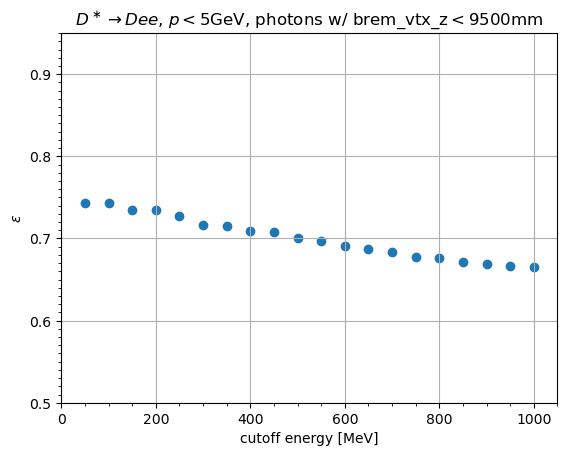

In [8]:
x_ = np.arange(50,1050,step=50)
plt.scatter(x_,efficiencies_found)
plt.xlabel("cutoff energy [MeV]")
plt.ylabel(r"$\epsilon$")
plt.title(r'$D^\ast\rightarrow Dee$, $p<5$GeV, photons w/ brem_vtx_z$<9500$mm')
plt.ylim([0.5,0.95])
plt.yticks(np.arange(0.5,0.96,step=0.01),minor=True)
plt.xticks(np.arange(0,1100,step=50),minor=True)
plt.grid()
plt.show()

In [9]:
#wie viel energie relativ zur anfangsenergie verlieren die elektronen durch bremstrahlung und hat das einen einfluss darauf ob wir sie finden oder nicht?

cutoff_energy=350

brem_found = acc_brem_found[ak.sum(acc_brem_found["brem_photons_pe"],axis=-1,keepdims=False)>=cutoff_energy]
energy_found = ak.to_numpy(brem_found["energy"])
eph_found = ak.to_numpy(ak.sum(brem_found["brem_photons_pe"], axis=-1, keepdims=False))
residual_found = energy_found - eph_found
energyloss_found = eph_found/energy_found

brem_lost = acc_brem_lost[ak.sum(acc_brem_lost["brem_photons_pe"],axis=-1,keepdims=False)>=cutoff_energy]
energy_lost = ak.to_numpy(brem_lost["energy"])
eph_lost = ak.to_numpy(ak.sum(brem_lost["brem_photons_pe"], axis=-1, keepdims=False))
residual_lost = energy_lost - eph_lost
energyloss_lost = eph_lost/energy_lost

print("eff = ", np.round(t_eff(brem_found,brem_lost),4), "+/-", np.round(eff_err(brem_found, brem_lost),4))
brem_lost

eff =  0.4993 +/- 0.0093


<Array [{energy: 4.19e+03, ...}, ..., {...}] type='1452 * {energy: float64,...'>

In [10]:
mean_energyloss_found = ak.mean(energyloss_found)
mean_energyloss_lost = ak.mean(energyloss_lost)
print("mean energyloss relative to initial energy (found): ", np.round(mean_energyloss_found,4))
print("mean energyloss relative to initial energy (lost): ", np.round(mean_energyloss_lost,4))

mean energyloss relative to initial energy (found):  0.3135
mean energyloss relative to initial energy (lost):  0.4443


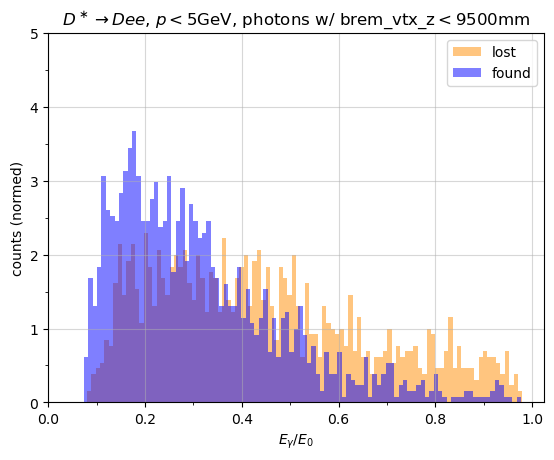

In [11]:
plt.hist(energyloss_lost, bins=100, density=True, alpha=0.5, histtype='bar', color="darkorange", label="lost")
plt.hist(energyloss_found, bins=100, density=True, alpha=0.5, histtype='bar', color="blue", label="found")
plt.xticks(np.arange(0,1.1,0.1), minor=True,)
plt.yticks(np.arange(0,5.5,0.5), minor=True)
plt.xlabel(r"$E_\gamma/E_0$")
plt.ylabel("counts (normed)")
plt.title(r'$D^\ast\rightarrow Dee$, $p<5$GeV, photons w/ brem_vtx_z$<9500$mm')
plt.legend()
plt.grid(alpha=0.5)

"""
found: elektronen verlieren durchschnittlich 0.44 ihrer anfangsenergie durch bremsstrahlung
lost: elektronen verlieren durchschnittlich 0.59 ihrer anfangsenergie durch bremsstrahlung

-> lost electrons lose slightly more energy than found electrons. This is however nowhere near as extreme as for the B decay
"""

#check if pt near 1 have small eta; perhaps exclude pt with eta outside range; or 2d plot

plt.show()

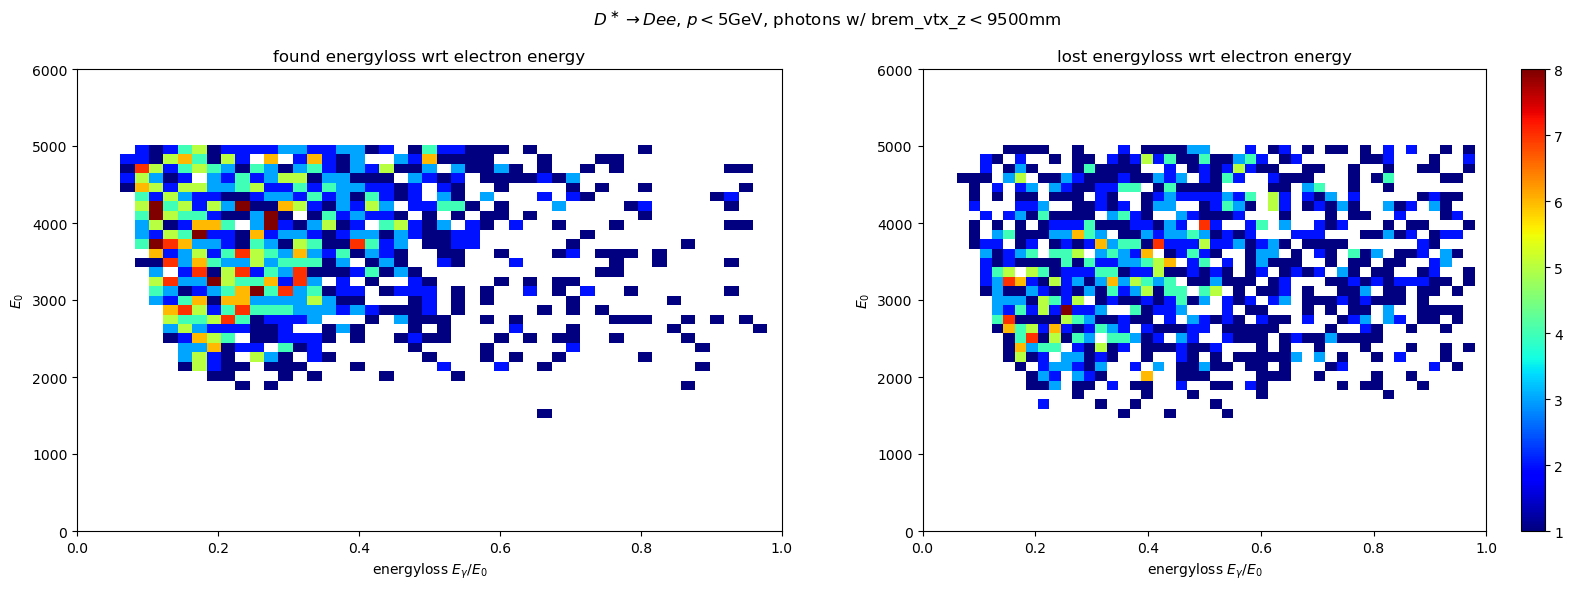

In [12]:
#energyloss in abh von der energie der elektronen

fig, ((ax0, ax1)) = plt.subplots(nrows=1, ncols=2, figsize=(20,6))

a0=ax0.hist2d(energyloss_found, energy_found, bins=(np.linspace(0,1,50), np.linspace(0,6e3,50)), cmap=plt.cm.jet, cmin=1, vmax=8)
ax0.set_ylim(0,6e3)
ax0.set_xlim(0,1)
ax0.set_xlabel(r"energyloss $E_\gamma/E_0$")
ax0.set_ylabel(r"$E_0$")
ax0.set_title("found energyloss wrt electron energy")

a1=ax1.hist2d(energyloss_lost, energy_lost, bins=(np.linspace(0,1,50), np.linspace(0,6e3,50)), cmap=plt.cm.jet, cmin=1, vmax=8)
ax1.set_ylim(0,6e3)
ax1.set_xlim(0,1)
ax1.set_xlabel(r"energyloss $E_\gamma/E_0$")
ax1.set_ylabel(r"$E_0$")
ax1.set_title("lost energyloss wrt electron energy")

fig.colorbar(a1[3],ax=ax1)
fig.suptitle(r"$D^\ast\rightarrow D ee$, $p<5$GeV, photons w/ brem_vtx_z$<9500$mm")


plt.show()

In [13]:
#ist die shape der teilspur im scifi anders? (koenntest du zum beispiel durch vergleich der verteilungen der fit parameter studieren,
#in meiner thesis findest du das fitmodell -- ist einfach ein polynom dritten grades)
z_ref=8520 #mm

def scifi_track(z, a, b, c, d):
    return a + b*(z-z_ref) + c*(z-z_ref)**2 + d*(z-z_ref)**3

def z_mag(xv, zv, tx, a, b):
    """ optical centre of the magnet is defined as the intersection between the trajectory tangents before and after the magnet

    Args:
        xv (double): velo x track
        zv (double): velo z track
        tx (double): velo x slope
        a (double): ax parameter of track fit
        b (double): bx parameter of track fit

    Returns:
        double: z_mag
    """
    return (xv-tx*zv-a+b*z_ref)/(b-tx)

In [14]:
scifi_found = found[found["scifi_hit_pos_x_length"]>3]
scifi_lost = lost[lost["scifi_hit_pos_x_length"]>3]

scifi_x_found = scifi_found["scifi_hit_pos_x"]
scifi_z_found = scifi_found["scifi_hit_pos_z"]

tx_found = scifi_found["velo_track_tx"]

scifi_x_lost = scifi_lost["scifi_hit_pos_x"]
scifi_z_lost = scifi_lost["scifi_hit_pos_z"]

tx_lost = scifi_lost["velo_track_tx"]

xv_found = scifi_found["velo_track_x"]
zv_found = scifi_found["velo_track_z"]

xv_lost = scifi_lost["velo_track_x"]
zv_lost = scifi_lost["velo_track_z"]



#ak.num(scifi_found["energy"], axis=0)
#scifi_found.snapshot()

In [15]:
scifi_fitpars_found = ak.ArrayBuilder()

for i in range(0,ak.num(scifi_found["energy"], axis=0)):
    popt, pcov = curve_fit(scifi_track,ak.to_numpy(scifi_z_found[i,:]),ak.to_numpy(scifi_x_found[i,:]))
    scifi_fitpars_found.begin_list()
    scifi_fitpars_found.real(popt[0])
    scifi_fitpars_found.real(popt[1])
    scifi_fitpars_found.real(popt[2])
    scifi_fitpars_found.real(popt[3])
    scifi_fitpars_found.end_list()

scifi_fitpars_lost = ak.ArrayBuilder()

for i in range(0,ak.num(scifi_lost["energy"], axis=0)):
    popt, pcov = curve_fit(scifi_track,ak.to_numpy(scifi_z_lost[i,:]),ak.to_numpy(scifi_x_lost[i,:]))
    scifi_fitpars_lost.begin_list()
    scifi_fitpars_lost.real(popt[0])
    scifi_fitpars_lost.real(popt[1])
    scifi_fitpars_lost.real(popt[2])
    scifi_fitpars_lost.real(popt[3])
    scifi_fitpars_lost.end_list()


scifi_fitpars_lost = scifi_fitpars_lost.to_numpy()
scifi_fitpars_found = scifi_fitpars_found.to_numpy()



dtx_found = scifi_fitpars_found[:,1] - tx_found
dtx_lost = scifi_fitpars_lost[:,1] - tx_lost


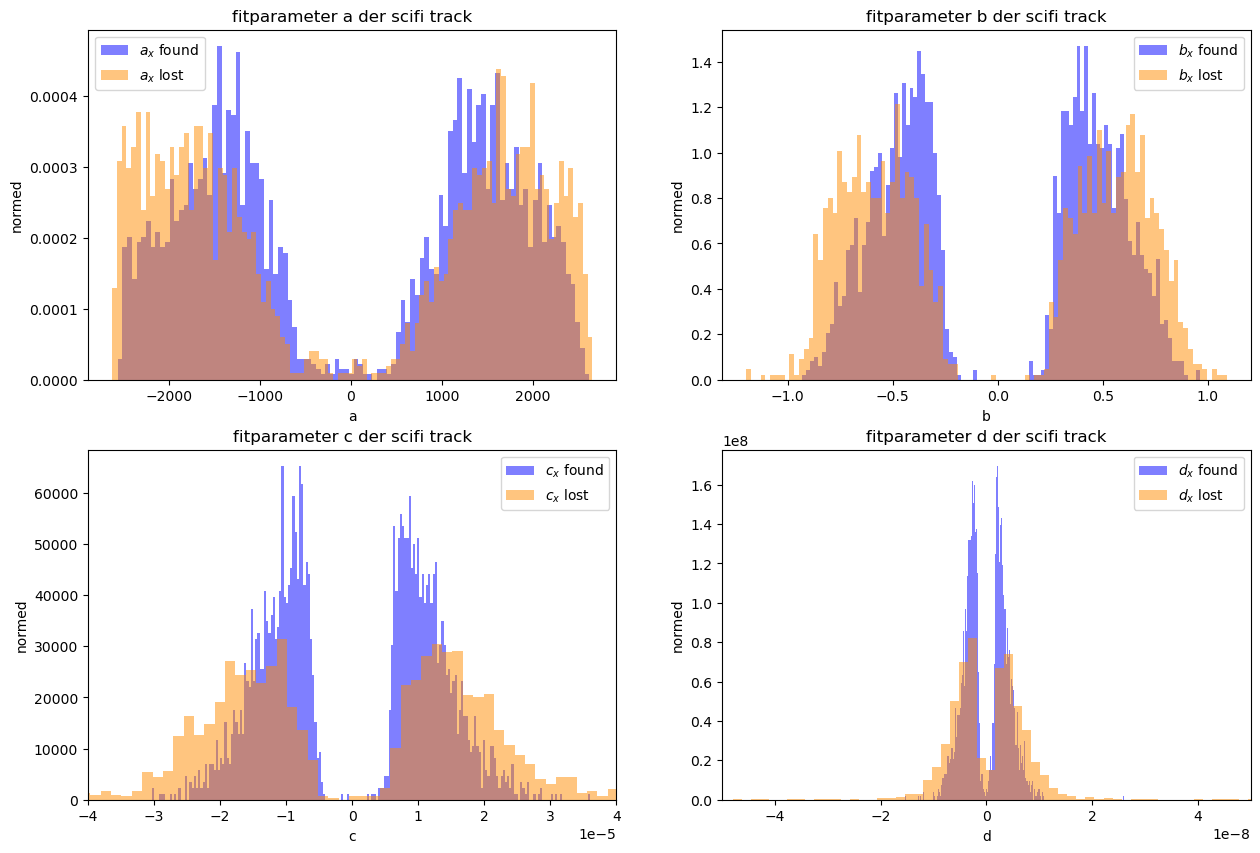

In [16]:
fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(nrows=2, ncols=2, figsize=(15,10))

ax0.hist(scifi_fitpars_found[:,0], bins=100, density=True, alpha=0.5, histtype='bar', color="blue", label=r"$a_x$ found")
ax0.hist(scifi_fitpars_lost[:,0], bins=100, density=True, alpha=0.5, histtype='bar', color="darkorange", label=r"$a_x$ lost")
ax0.set_xlabel("a")
ax0.set_ylabel("normed")
ax0.set_title("fitparameter a der scifi track")
ax0.legend()

ax1.hist(scifi_fitpars_found[:,1], bins=100, density=True, alpha=0.5, histtype='bar', color="blue", label=r"$b_x$ found")
ax1.hist(scifi_fitpars_lost[:,1], bins=100, density=True, alpha=0.5, histtype='bar', color="darkorange", label=r"$b_x$ lost")
ax1.set_xlabel("b")
ax1.set_ylabel("normed")
ax1.set_title("fitparameter b der scifi track")
ax1.legend()

ax2.hist(scifi_fitpars_found[:,2], bins=200, density=True, alpha=0.5, histtype='bar', color="blue", label=r"$c_x$ found")
ax2.hist(scifi_fitpars_lost[:,2], bins=1000, density=True, alpha=0.5, histtype='bar', color="darkorange", label=r"$c_x$ lost")
ax2.set_xlim([-4e-5,4e-5])
ax2.set_xticks(np.arange(-4e-5,4.5e-5,1e-5),minor=False)
ax2.set_xlabel("c")
ax2.set_ylabel("normed")
ax2.set_title("fitparameter c der scifi track")
ax2.legend()

ax3.hist(scifi_fitpars_found[:,3], bins=200, density=True, alpha=0.5, histtype='bar', color="blue", label=r"$d_x$ found")
ax3.hist(scifi_fitpars_lost[:,3], bins=1000, density=True, alpha=0.5, histtype='bar', color="darkorange", label=r"$d_x$ lost")
ax3.set(xlim=(-5e-8,5e-8))
#ax3.text(-4e-8,3e8,"d negligible <1e-7")
ax3.set_xlabel("d")
ax3.set_ylabel("normed")
ax3.set_title("fitparameter d der scifi track")
ax3.legend()

"""
a_x: virtual hit on the reference plane
"""

plt.show()

In [17]:
print("found")
print("a = ", str(np.mean(scifi_fitpars_found[:,0])))
print("b = ", str(np.mean(scifi_fitpars_found[:,1])))
print("c = ", str(np.mean(scifi_fitpars_found[:,2])))
print("d = ", str(np.mean(scifi_fitpars_found[:,3])))

print("lost")
print("a = ", str(np.mean(scifi_fitpars_lost[:,0])))
print("b = ", str(np.mean(scifi_fitpars_lost[:,1])))
print("c = ", str(np.mean(scifi_fitpars_lost[:,2])))
print("d = ", str(np.mean(scifi_fitpars_lost[:,3])))

found
a =  18.04180550457298
b =  0.0057651944487250376
c =  9.480277789440454e-08
d =  -4.452015498411874e-11
lost
a =  -35.48371609662243
b =  -0.010382326385451382
c =  -6.208301288913938e-07
d =  9.580933791481267e-11


In [18]:
np.min(scifi_fitpars_found[:,3])

-1.5438992626615335e-08

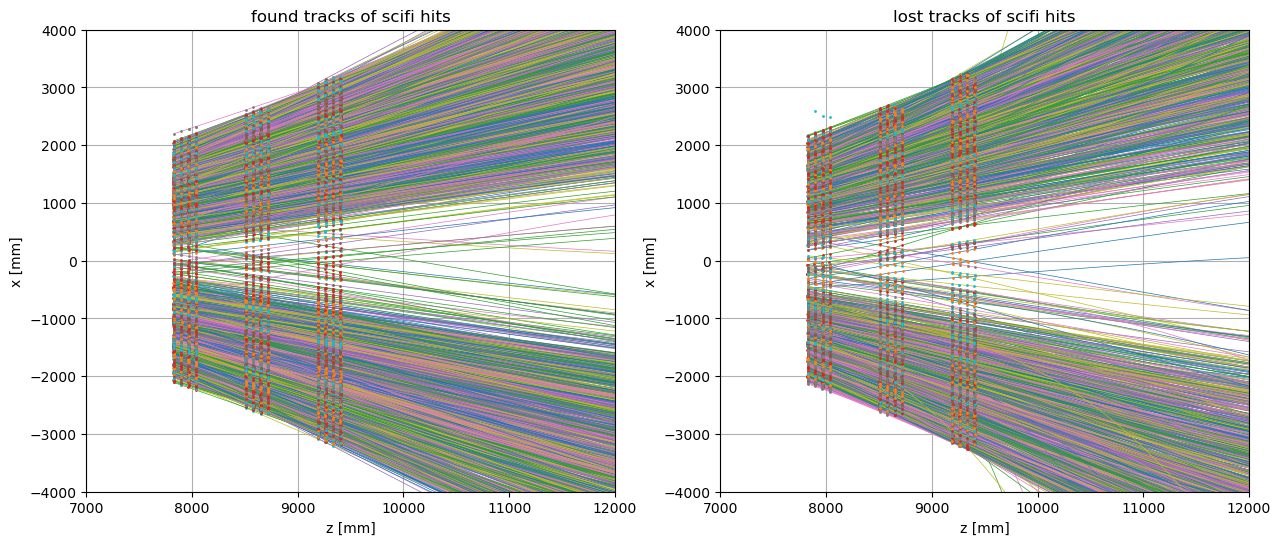

In [19]:
fig, ((ax0, ax1)) = plt.subplots(nrows=1, ncols=2, figsize=(15,6))

for i in range(0,ak.num(scifi_found["energy"], axis=0)):
    z_coord = np.linspace(scifi_z_found[i,0],12000,300)
    fit = scifi_track(z_coord, *scifi_fitpars_found[i])
    ax0.plot(z_coord, fit, "-", lw=0.5)
    ax0.errorbar(ak.to_numpy(scifi_z_found[i,:]),ak.to_numpy(scifi_x_found[i,:]),fmt=".",ms=2)

#ax0.legend()
ax0.set_xlabel("z [mm]")
ax0.set_ylabel("x [mm]")
ax0.set_title("found tracks of scifi hits")
ax0.set(xlim=(7e3,12000), ylim=(-4000,4000))
ax0.grid()

for i in range(0,ak.num(scifi_lost["energy"], axis=0)):
    z_coord = np.linspace(scifi_z_lost[i,0],12000,300)
    fit = scifi_track(z_coord, *scifi_fitpars_lost[i])
    ax1.plot(z_coord, fit, "-", lw=0.5)
    ax1.errorbar(ak.to_numpy(scifi_z_lost[i,:]),ak.to_numpy(scifi_x_lost[i,:]),fmt=".",ms=2)

#ax1.legend()
ax1.set_xlabel("z [mm]")
ax1.set_ylabel("x [mm]")
ax1.set_title("lost tracks of scifi hits")
ax1.set(xlim=(7e3,12000), ylim=(-4000,4000))
ax1.grid()

plt.show()

In [20]:
#vergleich der zmag werte
zmag_found = z_mag(xv_found, zv_found, tx_found, scifi_fitpars_found[:,0], scifi_fitpars_found[:,1])
zmag_lost = z_mag(xv_lost, zv_lost, tx_lost, scifi_fitpars_lost[:,0], scifi_fitpars_lost[:,1])
zmag_lost = zmag_lost[~np.isnan(zmag_lost)]
zmag_found = zmag_found[~np.isnan(zmag_found)]

print("found \nzmag = ", str(np.mean(zmag_found)))
print("lost \nzmag = ", str(np.mean(zmag_lost)))

found 
zmag =  5318.452650242005
lost 
zmag =  5425.137423441005


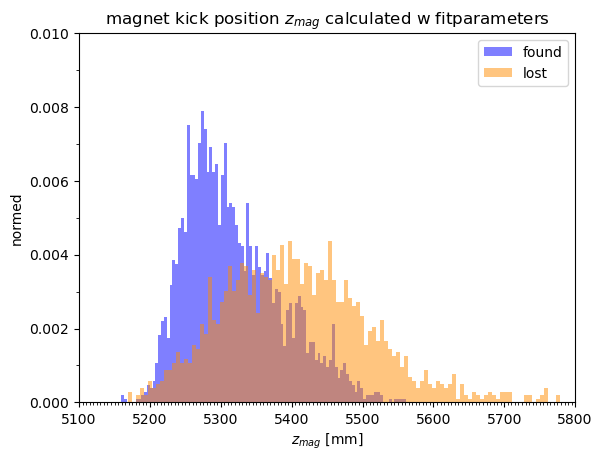

In [21]:
plt.hist(zmag_found, bins=100, density=True, alpha=0.5, histtype='bar', color="blue", label="found")
plt.hist(zmag_lost, bins=3000, density=True, alpha=0.5, histtype="bar",color="darkorange", label="lost")
plt.xlabel("$z_{mag}$ [mm]")
plt.ylabel("normed")
plt.title("magnet kick position $z_{mag}$ calculated w fitparameters")
plt.legend()
plt.xticks(np.arange(5100,5805,5), minor=True)
plt.yticks(np.arange(0,0.011,0.001), minor=True)
plt.xlim(5100,5800)

"""
wir können definitiv einen unterschied zwischen den z_mag werten, bzw deren verteilungen für lost and found, erkennen
"""

plt.show()

In [22]:
both = ak.concatenate([found,lost],axis=0)
print(ak.num(found,axis=0))
print(ak.num(lost,axis=0))
print(ak.num(both,axis=0))

tracks = allcolumns[(allcolumns.fromSignal) & (allcolumns.isElectron) & (~allcolumns.lost)]
alltracks = allcolumns[(allcolumns.fromSignal) & (allcolumns.isElectron)]
print(ak.num(tracks,axis=0))

2591
1908
4499
5767


In [23]:
#versuche teilchen von denselben events mit shared tracks zu finden. 
#idee: alle teilchen eines events sind durch event_count auffindbar. 
a_f_itr = tracks["event_count"].to_numpy()
f_itr = np.unique(a_f_itr)

shared = ak.ArrayBuilder()
count = 0

for itr in f_itr:
    temp = alltracks[alltracks["event_count"]==itr]
    if ak.num(temp,axis=0)>1:
        #iterate over cols in temp and append all with duplicate velo_track_idx, such that possibles is array with possible shared tracks particles
        #idea: look at one event at a time and at one velo track at a time. if there are at least two e with the same velo_track_idx in the same event,
        #concatenate to the array of other shared track particles
        _jitr = temp["velo_track_idx"].to_numpy()
        jitr = np.unique(_jitr)
        for jentry in jitr:
            jtem = temp[temp["velo_track_idx"]==jentry]
            if ak.num(jtem,axis=0)>1:
                shared.append(jtem)
            else:
                continue
    else:
        continue
shared = ak.Array(shared)

idx=0
print("#events w/ shared track electrons from found and lost: ",ak.num(shared, axis=0))

print("event_count: ", shared[idx,:,"event_count"])
print("velo idx: " ,shared[idx,:,"velo_track_idx"])
print("mcp_index: ", shared[idx,:,"mcp_idx"])

print("\nvelo x: " ,shared[idx,:,"velo_track_x"])
print("velo y: " ,shared[idx,:,"velo_track_y"])

print("\nvelo tx: " ,shared[idx,:,"velo_track_tx"])
print("velo ty: " ,shared[idx,:,"velo_track_ty"])



print("percentage of e with shared tracks: ", np.round((ak.num(shared,axis=0)*2)/(ak.num(alltracks,axis=0))*100,4)) #error for percentage

#events w/ shared track electrons from found and lost:  35
event_count:  [359, 359]
velo idx:  [25, 25]
mcp_index:  [2926, 2936]

velo x:  [5.89, 5.89]
velo y:  [9.81, 9.81]

velo tx:  [0.00824, 0.00824]
velo ty:  [0.0135, 0.0135]
percentage of e with shared tracks:  0.7488


In [24]:
#electrons with same velo_track_idx from all events
temp_ = found["velo_track_idx"].to_numpy()
temp = np.unique(temp_)
count=0
psb=ak.ArrayBuilder()
for jentry in temp:
    jtem = found[found["velo_track_idx"]==jentry]
    if ak.num(jtem,axis=0)>1:
        psb.append(jtem)
    else:
        continue

psb = ak.Array(psb)

print("#velo_track_idx in all events: ",ak.num(psb,axis=0))
idx = 0
print("velo idx: " ,psb[idx,:,"velo_track_idx"])
print("mcp_index: ", psb[idx,:,"mcp_idx"])
print("event_count: ", psb[idx,:,"event_count"])
print("\nvelo x: " ,psb[idx,:,"velo_track_x"])
print("velo y: " ,psb[idx,:,"velo_track_y"])

print("\nvelo tx: " ,psb[idx,:,"velo_track_tx"])
print("velo ty: " ,psb[idx,:,"velo_track_ty"])



#velo_track_idx in all events:  217
velo idx:  [0, 0, 0]
mcp_index:  [1066, 1251, 666]
event_count:  [5735, 7049, 7378]

velo x:  [-2.21, 9.45, -18.5]
velo y:  [-21.6, -33.4, 17.4]

velo tx:  [-0.0022, 0.0153, -0.0224]
velo ty:  [-0.0263, -0.0469, 0.0212]


In [25]:
#generell: wie viele elektronen von photon conversions teilen sich einen track?
conv = allcolumns[(allcolumns.fromPairProd) & (allcolumns.isElectron) & (~allcolumns.lost)]

conv_it = conv["event_count"].to_numpy()
conv_itr = np.unique(conv_it)

cshared = ak.ArrayBuilder()
count = 0

for itr in conv_itr:
    temp = conv[conv["event_count"]==itr]
    if ak.num(temp,axis=0)>1:
        #iterate over cols in temp and append all with duplicate velo_track_idx, such that possibles is array with possible shared tracks particles
        #idea: look at one event at a time and at one velo track at a time. if there are at least two e with the same velo_track_idx in the same event,
        #concatenate to the array of other shared track particles
        _jitr = temp["velo_track_idx"].to_numpy()
        jitr = np.unique(_jitr)
        for jentry in jitr:
            jtem = temp[temp["velo_track_idx"]==jentry]
            if ak.num(jtem,axis=0)>1:
                cshared.append(jtem)
            else:
                continue
    else:
        continue
cshared = ak.Array(cshared)


print("#events w/ shared track electrons from Photon Conversions: ",ak.num(cshared, axis=0))
idx = 0
print("shared_idx: ", idx)
print("event_count: ", cshared[idx,:,"event_count"])
print("velo idx: " ,cshared[idx,:,"velo_track_idx"])
print("mcp_index: ", cshared[idx,:,"mcp_idx"])

print("\nvelo x: " ,cshared[idx,:,"velo_track_x"])
print("velo y: " ,cshared[idx,:,"velo_track_y"])

print("\nvelo tx: " ,cshared[idx,:,"velo_track_tx"])
print("velo ty: " ,cshared[idx,:,"velo_track_ty"])

print("percentage of e with shared tracks: ", np.round((ak.num(cshared,axis=0)*2)/(ak.num(conv,axis=0))*100,4))

#constrain z pos of brem vtx; only interested in conversions in velo z<770


#events w/ shared track electrons from Photon Conversions:  951
shared_idx:  0
event_count:  [11, 11]
velo idx:  [27, 27]
mcp_index:  [1211, 1215]

velo x:  [-20.4, -20.4]
velo y:  [-24.4, -24.4]

velo tx:  [-0.0234, -0.0234]
velo ty:  [-0.028, -0.028]
percentage of e with shared tracks:  5.59


In [26]:
ak.num(conv,axis=0)

34025

In [27]:
"""
was meinst du? velo track sharen? wie überprüfe ich das? versuche ich einfach e teilchen mit identischen velo tracks und slopes zu finden?
benutze ich mother key um elektronen von gleichen events zu finden? meinst du wie viele elektronen vom selben event teilen sich einen track,
oder wie viele teilchen von unterschiedlichen events haben dieselben tracks?
"""


'\nwas meinst du? velo track sharen? wie überprüfe ich das? versuche ich einfach e teilchen mit identischen velo tracks und slopes zu finden?\nbenutze ich mother key um elektronen von gleichen events zu finden? meinst du wie viele elektronen vom selben event teilen sich einen track,\noder wie viele teilchen von unterschiedlichen events haben dieselben tracks?\n'